<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step4b_predict_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepPoseKit Step 4b - Predict on new data

This is step 4b of the example notebooks for using DeepPoseKit. This notebook shows you how to use your trained model to make predictions on a novel video, detect outliers, merge the outliers with the existing annotation set, and visualize the data output.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

**If you're using Colab**: make sure to go to the “Runtime” dropdown menu, select “Change runtime type” and select `GPU` in the "Hardware accelerator" drop-down menu


If you haven't already installed DeepPoseKit you can run the next cell

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
!{sys.executable} -m pip install -U deepposekit

Requirement already up-to-date: deepposekit in /usr/local/lib/python3.6/dist-packages (0.3.9)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from deepposekit.models import load_model
from deepposekit.io import DataGenerator, VideoReader, VideoWriter
from deepposekit.io.utils import merge_new_images

import tqdm
import time

from scipy.signal import find_peaks

from os.path import expanduser
try:
    import google.colab
    IN_COLAB = True
    HOME = '/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom'
    video_file_path = '/human/'
    video_file_name = 'pose_human_test.mp4'
        
except:
    IN_COLAB = False
    HOME = 'E:\\Work\\github repos\\deepposekit_data_custom'
    video_file_path = '\\human\\'
    video_file_name = 'pose_human_test.mp4'

#HOME = expanduser("~") if not IN_COLAB else '.'

Use the next cell to download the example data into your home directory

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
!git clone https://github.com/jgraving/deepposekit-data {HOME + '/deepposekit-data'}

fatal: Too many arguments.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    -n, --no-checkout     don't create a checkout
    --bare                create a bare repository
    --mirror              create a mirror repository (implies bare)
    -l, --local           to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    -s, --shared          setup as shared repository
    --recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    -j, --jobs <n>        number of submodules cloned in parallel
    --template <template-directory>
                          directory from which templates will be used
    --reference <repo>    reference repository
    --reference-if-able <repo>
                          reference repository
    --dissociate          use --reference only 

Find the saved models

In [6]:
models = sorted(glob.glob(HOME + video_file_path + '*model*.h5'))
models

['/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/best_model_densenet.h5']

# Load the trained model

This loads the trained model into memory for making predictions

In [7]:
model = load_model(HOME + video_file_path + 'best_model_densenet.h5')

Find the available videos

In [8]:
videos = sorted(glob.glob(HOME + video_file_path + '*.mp4'))
videos

['/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/pose_human_test.mp4',
 '/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/pose_human_test_resized.mp4',
 '/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/pose_human_test_resized_pose.mp4']

# Test the video

Check to make sure `VideoReader` is correctly loading the video frames

In [9]:
reader = VideoReader(HOME + video_file_path + 'pose_human_test.mp4', batch_size=10, gray=True)
frames = reader[0]
reader.close()

True

In [10]:
frames.shape

(10, 720, 1280, 1)

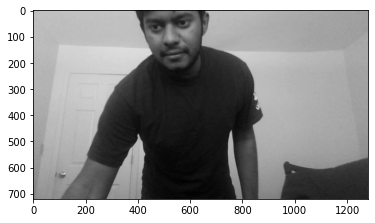

In [11]:
plt.imshow(frames[0,...,0], cmap='gray')
plt.show()

In [12]:
resize_shape = (640, 320)

In [13]:
cap = cv2.VideoCapture(HOME + video_file_path + 'pose_human_test.mp4')
 
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter(HOME + video_file_path + 'pose_human_test_resized.mp4',fourcc, 30, resize_shape)

out = VideoWriter(HOME + video_file_path + 'pose_human_test_resized.mp4', resize_shape, 'mp4v', 30.0, color=True)

while True:
    ret, frame = cap.read()
    if ret == True:
        b = cv2.resize(frame,resize_shape,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        out.write(b)
    else:
        break
    
cap.release()
out.close()
cv2.destroyAllWindows()

In [14]:
# import cv2
# vidcap = cv2.VideoCapture(HOME + video_file_path + 'pose_human_test.mp4')
# success,image = vidcap.read()
# count = 0;
# print ("I am in success")
# while success:
#   success,image = vidcap.read()
#   print(image.shape)
#   if ~success:
#     break
  
#   resize = cv2.resize(image, resize_shape) 
#   cv2.imwrite("%03d.jpg" % count, resize)     
#   if cv2.waitKey(10) == 27:                     
#       break
#   count += 1
# print('done')

# Makes predictions for the full video

This loads batches of frames and makes predictions.

In [15]:
reader = VideoReader(HOME + video_file_path + 'pose_human_test_resized.mp4', batch_size=100, gray=True)
predictions = model.predict(reader, verbose=1)
reader.close()


3/3 [==============================] - 13s 2s/step


True

# Save the data

Once you have your predictions you can save it however you wish. Here is an example using numpy.save

In [16]:
np.save(HOME + video_file_path + 'predictions.npy', predictions)

This splits the predictions into their x-y coordinates, and confidence scores from each confidence map.

In [17]:
x, y, confidence = np.split(predictions, 3, -1)

Visualize the data output

/usr/local/lib/python3.6/dist-packages/deepposekit/io/DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)


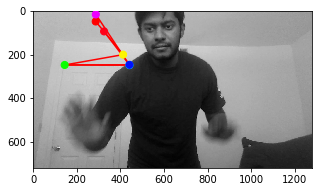

In [18]:
data_generator = DataGenerator(HOME + video_file_path + 'example_annotation_set.h5')

image = frames[9]
keypoints = predictions[9]

plt.figure(figsize=(5,5))
image = image if image.shape[-1] is 3 else image[..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[idx, 0], keypoints[jdx, 0]],
            [keypoints[idx, 1], keypoints[jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[:, 0], keypoints[:, 1],
            c=np.arange(data_generator.keypoints_shape[0]),
            s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Detect outlier frames

This is a basic example of how to use confidence scores and temporal derivatives to detect potential outliers and add them to the annotation set.

Plot the confidence scores

In [19]:
# confidence_diff = np.abs(np.diff(confidence.mean(-1).mean(-1)))

# plt.figure(figsize=(15, 3))
# plt.plot(confidence_diff)
# plt.show()

Use `scipy.signal.find_peaks` to detect outliers

In [20]:
# confidence_outlier_peaks = find_peaks(confidence_diff, height=0.1)[0]

# plt.figure(figsize=(15, 3))
# plt.plot(confidence_diff)
# plt.plot(confidence_outlier_peaks, confidence_diff[confidence_outlier_peaks], 'ro')
# plt.show()

Calculate the keypoint derivatives and plot them

In [21]:
# time_diff = np.diff(predictions[..., :2], axis=0)
# time_diff = np.abs(time_diff.reshape(time_diff.shape[0], -1))
# time_diff = time_diff.mean(-1)
# time_diff.shape

In [22]:
# plt.figure(figsize=(15, 3))
# plt.plot(time_diff)
# plt.show()

Use `scipy.signal.find_peaks` to detect outliers

In [23]:
# time_diff_outlier_peaks = find_peaks(time_diff, height=10)[0]

# plt.figure(figsize=(15, 3))
# plt.plot(time_diff)
# plt.plot(time_diff_outlier_peaks, time_diff[time_diff_outlier_peaks], 'ro')
# plt.show()

Combine the detected outliers into a single index

In [24]:
1+1

2

In [25]:
# outlier_index = np.concatenate((confidence_outlier_peaks, time_diff_outlier_peaks))
# outlier_index = np.unique(outlier_index) # make sure there are no repeats

Grab the frames and corresponding keypoints for the selected outliers

In [26]:
# reader = VideoReader(HOME + video_file_path + 'pose_human_test_resized.mp4', batch_size=1, gray=True)

# outlier_images = []
# outlier_keypoints = []
# for idx in outlier_index:
#     outlier_images.append(reader[idx])
#     outlier_keypoints.append(predictions[idx])

# outlier_images = np.concatenate(outlier_images)
# outlier_keypoints = np.stack(outlier_keypoints)

# reader.close()

# outlier_images.shape, outlier_keypoints.shape

Visualize the outlier frames and keypoint predictions

In [27]:
# data_generator = DataGenerator(HOME + video_file_path + 'example_annotation_set.h5')

# for idx in range(5):
#     image = outlier_images[idx]
#     keypoints = outlier_keypoints[idx]

#     plt.figure(figsize=(5,5))
#     image = image if image.shape[-1] is 3 else image[..., 0]
#     cmap = None if image.shape[-1] is 3 else 'gray'
#     plt.imshow(image, cmap=cmap, interpolation='none')
#     for idx, jdx in enumerate(data_generator.graph):
#         if jdx > -1:
#             plt.plot(
#                 [keypoints[idx, 0], keypoints[jdx, 0]],
#                 [keypoints[idx, 1], keypoints[jdx, 1]],
#                 'r-'
#             )
#     plt.scatter(keypoints[:, 0], keypoints[:, 1],
#                 c=np.arange(data_generator.keypoints_shape[0]),
#                 s=50, cmap=plt.cm.hsv, zorder=3)

#     plt.show()

# Merge outliers with the annotation set
Here we'll use a utility function `merge_new_images` to merge the outliers with our existing annotation set. You can then go annotate them with `deepposekit.annotate.Annotator`. Make sure to use the merged output file!

In [28]:
# merge_new_images(
#     datapath=HOME + video_file_path + 'example_annotation_set.h5',
#     merged_datapath=HOME + video_file_path + 'example_annotation_set_merged.h5',
#     images=outlier_images,
#     keypoints=outlier_keypoints,
#     overwrite=True # This overwrites the merged dataset if it already exists
# )

Load the data with `DataGenerator` and check that the merged data are there

In [29]:
# merged_generator = DataGenerator(HOME + video_file_path + 'example_annotation_set_merged.h5', mode="unannotated")

# image, keypoints = merged_generator[0]

# plt.figure(figsize=(5,5))
# image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
# cmap = None if image.shape[-1] is 3 else 'gray'
# plt.imshow(image, cmap=cmap, interpolation='none')
# for idx, jdx in enumerate(data_generator.graph):
#     if jdx > -1:
#         plt.plot(
#             [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
#             [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
#             'r-'
#         )
# plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

# plt.show()

# Visualize the data as a video

This is an example of how to visualize the predicted posture data on the original video.

In [30]:
resize_shape

(640, 320)

In [31]:
model_size = tuple(model.input_shape[:2])

In [32]:
model_size

(320, 640)

In [33]:
!pip install opencv-python 
!pip install opencv-contrib-python

In [51]:
# TODO: Turn this into a function
reader = VideoReader(HOME + video_file_path + 'pose_human_test_resized.mp4', batch_size=100, gray=True)
predictions = model.predict(reader, verbose=1)
reader.close()

3/3 [==============================] - 3s 841ms/step


True

In [52]:
predictions[...,:2].shape, predictions.shape

((275, 7, 2), (275, 7, 3))

In [53]:
HOME

'/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom'

In [62]:


data_generator = DataGenerator(HOME + video_file_path + 'example_annotation_set.h5')
predictions = predictions[...,:2]
#predictions *= 2

#resized_shape = (data_generator.image_shape[0]*2, data_generator.image_shape[1]*2)
cmap = plt.cm.hsv(np.linspace(0, 1, data_generator.keypoints_shape[0]))[:, :3][:, ::-1] * 255

#fourcc = cv2.VideoWriter_fourcc(*'XVID')
#writer = cv2.VideoWriter(HOME + video_file_path + 'pose_human_test_resized_pose.mp4',fourcc, 30, (640*2,320*2))
 
#writer = VideoWriter(HOME + video_file_path + 'fly_posture.mp4', (192*2,192*2), 'MP4V', 30.0)
#writer = VideoWriter(HOME + video_file_path + 'pose_human_test_resized_pose.mp4', (640, 320))
reader = VideoReader(HOME + video_file_path + 'pose_human_test_resized.mp4', batch_size=1)
writer = VideoWriter(HOME + video_file_path + 'pose_human_test_resized_pose.mp4', model_size, 'mp4v', 30.0)

for frame, keypoints in tqdm.tqdm(zip(reader, predictions)):
    frame = frame[0]
    #frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    #frame = frame.copy()
    
    #print(frame.shape, keypoints.shape)
    #frame = cv2.resize(frame, (640*2,320*2))
    for idx, node in enumerate(data_generator.graph):
        if node >= 0:
            pt1 = keypoints[idx]
            pt2 = keypoints[node]
            cv2.line(frame, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0,0,255), 2, cv2.LINE_AA)
    for idx, keypoint in enumerate(keypoints):
        keypoint = keypoint.astype(int)
        cv2.circle(frame, (keypoint[0], keypoint[1]), 5, tuple(cmap[idx]), -1, lineType=cv2.LINE_AA)
        
    writer.write(frame)

writer.close()
reader.close()
#writer.release()
cv2.destroyAllWindows()

/usr/local/lib/python3.6/dist-packages/deepposekit/io/DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)
275it [00:00, 1026.67it/s]


TypeError: ignored

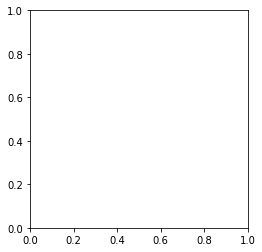

In [38]:
plt.imshow(frame[...,::-10])
plt.show()

In [41]:
HOME + video_file_path + video_file_name

'/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/pose_human_test.mp4'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
print("Using tensorflow v" + str(tf.__version__))


# HOW TO USE THIS SCRIPT:

# 1. Update the source
# 2. Make sure annotator is uncommented
# 3. Maybe change the text scaling

from deepposekit import Annotator
from deepposekit.io import VideoReader, DataGenerator, initialize_dataset, TrainingGenerator, BaseGenerator
from deepposekit.io import ImageGenerator, VideoWriter
from deepposekit.io.utils import merge_new_images
from deepposekit.annotate import KMeansSampler
from deepposekit.augment import FlipAxis
from deepposekit.models import StackedDenseNet, DeepLabCut,StackedHourglass,LEAP
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
from scipy.signal import find_peaks

import tqdm
import cv2

import imgaug.augmenters as iaa
import imgaug as ia

from os.path import expanduser
try:
    import google.colab
    IN_COLAB = True
    HOME = '/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom'
    video_file_path = '/human/'
    video_file_name = 'pose_human_test.mp4'
        
except:
    IN_COLAB = False
    HOME = 'E:\\Work\\github repos\\deepposekit_data_custom'
    video_file_path = '\\human\\'
    video_file_name = 'pose_human_test.mp4'

TensorFlow 1.x selected.
Using tensorflow v1.15.2


In [4]:

def create_video():
    print("[INFO] Creating Output Video")

    with tf.device("gpu:0"):
        model = load_model(HOME + video_file_path  + 'best_model_densenet.h5')

    model_size = tuple(model.input_shape[:2])
    resize_shape = (640, 320)
    print("Reading Video...")
    reader = VideoReader(HOME + video_file_path + 'pose_human_test_resized.mp4', batch_size=1, gray=True)
    predictions = model.predict(reader, verbose=1)
    np.save(HOME + 'predictions.npy', predictions)
    #############################################

    data_generator = DataGenerator(HOME + video_file_path + 'example_annotation_set.h5')
    predictions = predictions[..., :2]
    print(predictions.shape)

    cmap = plt.cm.hsv(np.linspace(0, 1, data_generator.keypoints_shape[0]))[:, :3][:, ::-1] * 255

    writer = VideoWriter(HOME + video_file_path + 'pose_human_test_resized_predicted.mp4', resize_shape, 'mp4v', 30.0, color=True)
    for frame, keypoints in tqdm.tqdm(zip(reader, predictions)):
        frame = frame[0]
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        for i, node in enumerate(data_generator.graph):
            if node >= 0:
                pt1 = keypoints[i]
                pt2 = keypoints[node]
                cv2.line(frame, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0, 0, 255), 1, cv2.LINE_AA)
        for i, keypoint in enumerate(keypoints):
            keypoint = keypoint.astype(int)
            cv2.circle(frame, (keypoint[0], keypoint[1]), 1, tuple(cmap[i]), -1, cv2.LINE_AA)
        writer.write(frame)

    writer.close()
    reader.close()



In [5]:
create_video()

[INFO] Creating Output Video
Reading Video...
275/275 [==============================] - 8s 29ms/step


/usr/local/lib/python3.6/dist-packages/deepposekit/io/DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)
0it [00:00, ?it/s]

(275, 7, 2)


275it [00:00, 408.86it/s]
